The challenge consists of a sentiment analysis problem where we want to identify tweets which are hate tweets and which are not (non-hate tweets).

In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import re

pd.set_option('display.max_colwidth', -1)

train = pd.read_csv('./train_E6oV3lV.csv', encoding='utf-8', header=0, names=['id','target','text'])
train['is_train'] = 1

test = pd.read_csv('./test_tweets_anuFYb8.csv', encoding='utf-8', header=0, names=['id', 'text'])
test['is_train'] = 0

# combine train and test data in order to preprocess only once
df = train.append(test, ignore_index=True)

df.head(5)

,id,is_train,target,text
0,1,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,1,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,1,0.0,bihday your majesty
3,4,1,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,1,0.0,factsguide: society now #motivation


Since we are dealing with english language UTF-8 encoding should work. Nevertheless, it can be observed that we do have some non-ascii characteres that need to be cleared out. These non-ascii characters come from different sources one of them being emoticons.

We can also observe some other particularities from the twitter world:

1. @user - masked user names for anonymity. We'll consider it irrelevant for the problem at hands and thus we will remove it;

2. \#getthanked - hashtags contain relevant information (it can be seen here https://www.analyticsvidhya.com/blog/2018/07/hands-on-sentiment-analysis-dataset-python/) so we'll keep them and remove only the \# symbol;

3. Abbreviations - in a more in-depth study it should be normalized to one form, in this case we will do it for a short list of abbreviations;

4. Contractions and abbreviations - (can't) vs (can not) vs (cannot) - some of these scenarios will be converted to a common form;

5. Stop words - words like 'the', 'to', etc do not add information to the approach that will be used and will end up contributing just as noise for the final model;

6. Stemming will be applied with the same purpose of finding a common form for a common meaning. This reduces the vocabulary by reducing words to the same root / stem.

7. All the text will be transformed into lowercase.

8. Remove HTML encoding - Example: ‘&amp’, ...

9. Remove URLs

10. Correct words as 'sooo goooood'

In [2]:
'''
Text normalization
'''
# remove URLs
df['clean_text'] = df['text'].apply(lambda x: re.sub(r'(http:\/\/www\.|https:\/\/www\.|http:\/\/|https:\/\/)?[a-z0-9]+([\-\.]{1}[a-z0-9]+)*\.[a-z]{2,5}(:[0-9]{1,5})?(\/.*)?', ' ', x.lower()))

# remove every * (star) except the ones that are connected with characters (usually swear words)
df['clean_text'] = df['clean_text'].apply(lambda x: re.sub(r"([a-z]+\*+[a-z]*)", ' swear ', x))

# remove non-ascii characters, punctuations, @user, html decoding, #, and transform to lowercase
df['clean_text'] = df['text'].apply(lambda x: re.sub(r"([^a-z@&0-9']|@user|&[\w+])", ' ', x))

# normalize contractions and some abbreviations
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
                   "can't've": "cannot have", "'cause": "because", "could've": "could have", 
                   "couldn't": "could not", "couldn't've": "could not have","didn't": "did not", 
                   "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                   "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", 
                   "he'd": "he would", "he'd've": "he would have", "he'll": "he will", 
                   "he'll've": "he will have", "he's": "he is", "how'd": "how did", 
                   "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
                   "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                   "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                   "i'd": "i would", "i'd've": "i would have", "i'll": "i will", 
                   "i'll've": "i will have","i'm": "i am", "i've": "i have", 
                   "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                   "it'll": "it will", "it'll've": "it will have","it's": "it is", 
                   "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                   "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                   "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
                   "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
                   "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                   "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                   "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                   "she's": "she is", "should've": "should have", "shouldn't": "should not", 
                   "shouldn't've": "should not have", "so've": "so have","so's": "so as","this's": "this is",
                   "that'd": "that would", "that'd've": "that would have","that's": "that is", 
                   "there'd": "there would", "there'd've": "there would have","there's": "there is", 
                    "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                   "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                   "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                   "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
                   "we're": "we are", "we've": "we have", "weren't": "were not", 
                   "what'll": "what will", "what'll've": "what will have", "what're": "what are", 
                   "what's": "what is", "what've": "what have", "when's": "when is", 
                   "when've": "when have", "where'd": "where did", "where's": "where is", 
                   "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                   "who's": "who is", "who've": "who have", "why's": "why is", 
                   "why've": "why have", "will've": "will have", "won't": "will not", 
                   "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                   "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                   "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                   "you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
                   "you'll've": "you will have", "you're": "you are", "you've": "you have"}

abbreviations = {"gr8": "great", "luv": "love", "social justice warrior": "sjw"}
                
def replace_mapping(text, mapping):
    for word in text.split():
        if word in mapping:
            # regular expression ensures that it is not an inner match. Example: 'great' doesn't match 'greatness'
            src_str = re.compile(r'((?<![a-z]){word}(?![a-z]))'.format(word=word), re.IGNORECASE)
            match = src_str.search(text)            
            text = text.replace(word, mapping[word.lower()])
            if match:
                text = src_str.sub(mapping[word],text)
                
    return text
                
df['clean_text'] = [replace_mapping(t, contractions) for t in df.clean_text]
df['clean_text'] = [replace_mapping(t, abbreviations) for t in df.clean_text]
                
# clean groups of digits + characters as: osd2016, #f4f, #euros2016, #taylorswift1989, 16th, #ham4ham 
df['clean_text'] = df['clean_text'].apply(lambda x: re.sub(r'([a-z]+[0-9]+[a-z]+|[a-z]+[0-9]+|[0-9]+[a-z]+)', ' ', x))

# numbers will be removed now - previously it was used to remove the combination above and to identify abbreviations
df['clean_text'] = df['clean_text'].apply(lambda x: re.sub(r"([0-9]+)", ' ', x))

# remove repetition of characters more than twice: 'sooooo greeeeeat' to 'soo greeat' < although it is not perfect it will reduce it to two forms: great and greeat.
df['clean_text'] = df['clean_text'].apply(lambda x: re.sub(r'(.)\1+', r'\1\1', x))

# short words rarely carry important meaning, so lets get rid of those too
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# remove stop words
from nltk.corpus import stopwords
stop = stopwords.words('english')

df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))

# apply stemming
from nltk.stem.porter import *
stemmer = PorterStemmer()

df['clean_text_stemmed'] = df['clean_text'].apply(lambda x: ' '.join([stemmer.stem(i) for i in x.split()]))

# get tokens clean_text
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
df['tokens'] = df['clean_text'].apply(tokenizer.tokenize)

# get tokens clean_text_stemmed
tokenizer = RegexpTokenizer(r'\w+')
df['tokens_stemmed'] = df['clean_text_stemmed'].apply(tokenizer.tokenize)

df.head(5)

,id,is_train,target,text,clean_text,clean_text_stemmed,tokens,tokens_stemmed
0,1,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,father dysfunctional selfish drags kids dysfunction,father dysfunct selfish drag kid dysfunct,"[father, dysfunctional, selfish, drags, kids, dysfunction]","[father, dysfunct, selfish, drag, kid, dysfunct]"
1,2,1,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks lyft credit cannot cause offer wheelchair vans disapointed getthanked,thank lyft credit cannot caus offer wheelchair van disapoint getthank,"[thanks, lyft, credit, cannot, cause, offer, wheelchair, vans, disapointed, getthanked]","[thank, lyft, credit, cannot, caus, offer, wheelchair, van, disapoint, getthank]"
2,3,1,0.0,bihday your majesty,bihday majesty,bihday majesti,"[bihday, majesty]","[bihday, majesti]"
3,4,1,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,model love take time,model love take time,"[model, love, take, time]","[model, love, take, time]"
4,5,1,0.0,factsguide: society now #motivation,factsguide society motivation,factsguid societi motiv,"[factsguide, society, motivation]","[factsguid, societi, motiv]"


Although the wordcloud is not a scientific method it does help to visually identify which words are more prevalent.

By using this method I ended up finding also some words that were contaminating the text and were removed above.

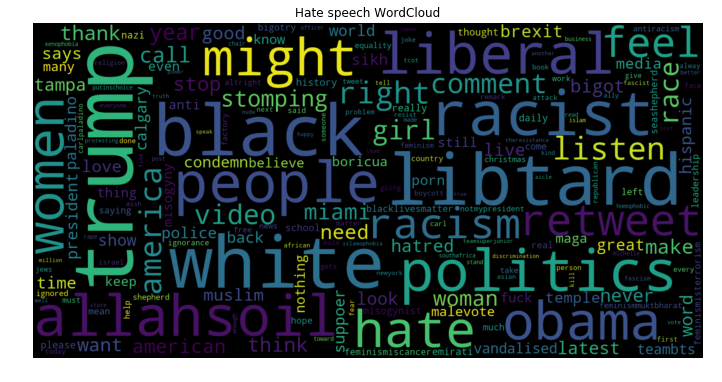

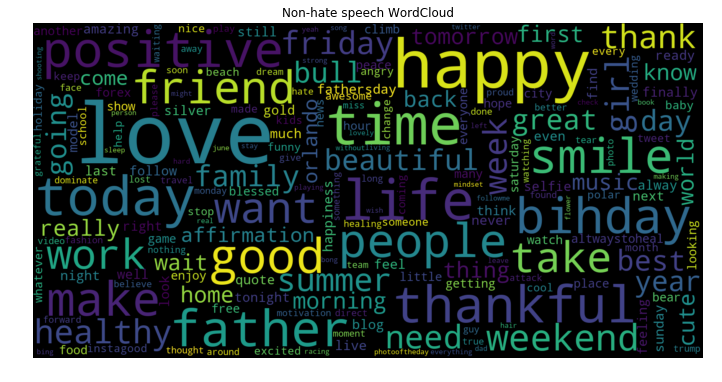

In [3]:
# labelled as hate speech
neg_tweets = df[df.target == 1]
neg_string = []
for t in neg_tweets.clean_text:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200, collocations=False).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Hate speech WordCloud')
plt.show()

# labelled as non-hate speech
pos_tweets = df[df.target == 0]
pos_string = []
for t in pos_tweets.clean_text:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200, collocations=False).generate(pos_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Non-hate speech WordCloud')
plt.show()

From the images above we can see that hate speech words do make sense - usually related with politics, races, gender, negative words, swearing, etc. In the wordcloud for non-hate speech we can find lot of non-hate and positive words. It is important to notice that we are considering only 1-grams here, which does not capture the context in which the word is inserted.

In both cases there's a lot of noisy words that could be excluded in a more detailed analysis.

In [4]:
# check class distribution
s_total = (df.is_train == 1).sum()
s_hate = (df.target == 1).sum()
s_non_hate = (df.target == 0).sum()

print('# of training samples: {}'.format(s_total))
print('# class 1 (hate speech) samples: {} / {}%'.format(s_hate, round(s_hate/s_total,2)))
print('# class 0 (non-hate speech) samples: {} / {}%'.format(s_non_hate, round(s_non_hate/s_total,2)))


# of training samples: 31962
# class 1 (hate speech) samples: 2242 / 0.07%
# class 0 (non-hate speech) samples: 29720 / 0.93%


The training set is imbalanced having 2242(0.07%) samples of hate speech and 29720(0.93%) samples of non-hate speech. In order to compare the percentage that a certain word shows up in one class vs the other we will re-scale to be as if there are the same number of samples for each class. That will be shown by the columns 'hate_pct_scaled' and 'non_hate_pct_scaled'.

In [5]:
# bag-of-words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
ctv_vec = CountVectorizer()
# bag-of-words feature matrix
ctv = ctv_vec.fit_transform(df.clean_text)
print('number of unique words: \n')
print(len(ctv_vec.get_feature_names()))

pos_doc_matrix = ctv_vec.transform(df[df.target == 0].clean_text)
neg_doc_matrix = ctv_vec.transform(df[df.target == 1].clean_text)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],columns=ctv_vec.get_feature_names()).transpose()
term_freq_df.columns = ['hate', 'non_hate']
term_freq_df['total'] = term_freq_df['non_hate'] + term_freq_df['hate']

import numpy as np

# re-scaling and compute percentages
factor = len(df[df.target == 0]) / len(df[df.target == 1])

term_freq_df['hate_scaled'] = term_freq_df['hate']
term_freq_df['non_hate_scaled'] = np.ceil(term_freq_df['non_hate']/factor).astype(int)
term_freq_df['total_scaled'] = term_freq_df['hate_scaled'] + term_freq_df['non_hate_scaled']
term_freq_df['hate_pct_scaled'] = term_freq_df['hate']/term_freq_df['total_scaled']
term_freq_df['non_hate_pct_scaled'] = term_freq_df['non_hate_scaled']/term_freq_df['total_scaled']

term_freq_df.sort_values(by='total_scaled', ascending=False).iloc[:10]

number of unique words: 

45276


,hate,non_hate,total,hate_scaled,non_hate_scaled,total_scaled,hate_pct_scaled,non_hate_pct_scaled
love,27,2819,2846,27,213,240,0.112500,0.887500
trump,213,182,395,213,14,227,0.938326,0.061674
like,139,920,1059,139,70,209,0.665072,0.334928
people,95,792,887,95,60,155,0.612903,0.387097
libtard,149,3,152,149,1,150,0.993333,0.006667
white,140,83,223,140,7,147,0.952381,0.047619
black,134,126,260,134,10,144,0.930556,0.069444
happy,12,1694,1706,12,128,140,0.085714,0.914286
racist,108,37,145,108,3,111,0.972973,0.027027
time,22,1127,1149,22,86,108,0.203704,0.796296


Given the percentages above (last two columns) it is possible now to identify single words that show up as often in both classes and thus can be considered as noise when using word counting as features.

In [6]:
# list words that have almost the same frequency in both classes
term_freq_df[(term_freq_df.hate_pct_scaled > 0.45) & (term_freq_df.hate_pct_scaled < 0.55)].sort_values(by='total_scaled', ascending=False).iloc[:10]

,hate,non_hate,total,hate_scaled,non_hate_scaled,total_scaled,hate_pct_scaled,non_hate_pct_scaled
never,34,386,420,34,30,64,0.531250,0.468750
think,33,376,409,33,29,62,0.532258,0.467742
girl,28,362,390,28,28,56,0.500000,0.500000
year,29,307,336,29,24,53,0.547170,0.452830
live,23,325,348,23,25,48,0.479167,0.520833
even,23,320,343,23,25,48,0.479167,0.520833
still,24,302,326,24,23,47,0.510638,0.489362
look,24,286,310,24,22,46,0.521739,0.478261
many,23,266,289,23,21,44,0.522727,0.477273
ever,23,242,265,23,19,42,0.547619,0.452381


# Modeling

When modeling, the first step we want to take is to define the performance metrics that we will use. The problem states that it will use f1 score to evaluate the results, nevertheless we will also look into recall and precision to better understand where is our model misclassifying (hate vs non-hate speech).

Accuracy will not be very informative in this context due to the data imbalance.

In [7]:
'''
Auxiliary functions
'''
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, average='binary')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, average='binary')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, average='binary')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    
    # AUC
    auc = roc_auc_score(y_test, y_predicted)
    return accuracy, precision, recall, f1, auc

def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(12, 12))  

    plt.subplot(211)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Non-hate speech', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=10)
    
    
    plt.subplot(212)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Hate speech', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=10)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

Now we will create some models (logistic regression and random forests) based on word of bags (bow) and term frequency–inverse document frequency (tf-idf) and explain its predictions by evaluating what features have more weight.

At last, in order to use an approach that takes into account the whole sentence (not only a restricted numbers of words - n-grams) we will use a CNN. That will also enable to discuss deep learning.

In [8]:
# split data into train set and validation set
df_train = df[df.is_train == 1]

from sklearn.model_selection import train_test_split
y = df_train.target.values
xtrain_id, xvalid_id, ytrain, yvalid = train_test_split(df_train.clean_text_stemmed, y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.15, shuffle=True)
xtrain = xtrain_id.values
xvalid = xvalid_id.values

In [9]:
print(xtrain.shape)
print(xvalid.shape)

(27167,)
(4795,)


number of unique words: 

14515
accuracy = 0.943, precision = 0.570, recall = 0.735, f1 = 0.642
auc = 0.847
[[4273  186]
 [  89  247]]


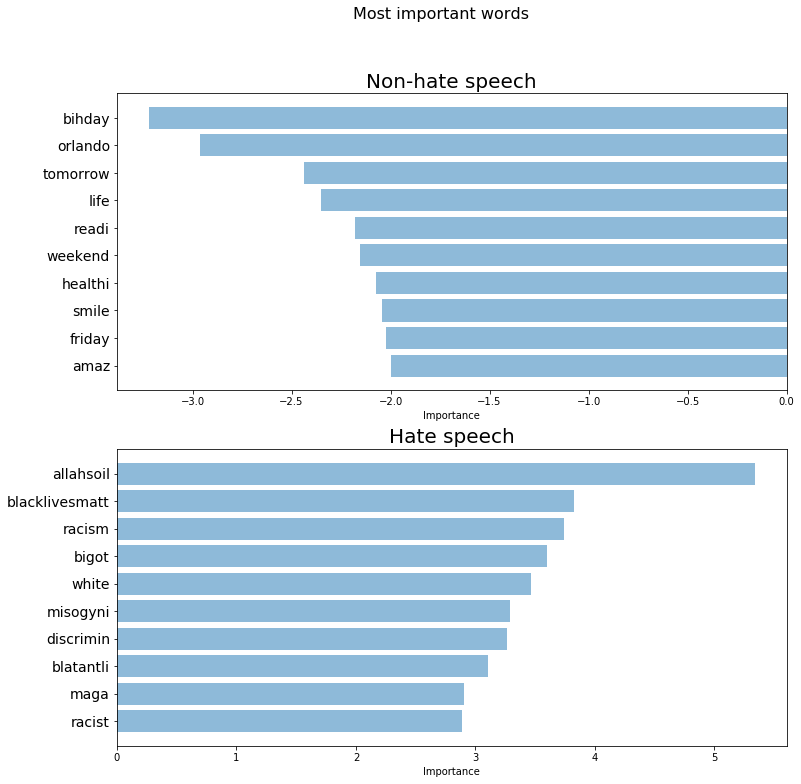

In [10]:
store_results = {}
'''
Logistic regression with bag of words features
'''
ctv = CountVectorizer(analyzer='word',
                      token_pattern=r'\w{1,}',
                      ngram_range=(1, 3),
                      stop_words = 'english',
                      min_df=3,
                      max_df=0.9)

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv.fit(list(xtrain) + list(xvalid))

print('number of unique words: \n')
print(len(ctv.get_feature_names()))

xtrain_ctv =  ctv.transform(xtrain) 
xvalid_ctv = ctv.transform(xvalid)

from sklearn.linear_model import LogisticRegression
# Fitting a simple Logistic Regression on Counts
clf = LogisticRegression(C=1.0, class_weight='balanced')
clf.fit(xtrain_ctv, ytrain)
predictions = clf.predict(xvalid_ctv)

accuracy, precision, recall, f1, auc = get_metrics(yvalid, predictions)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))
print("auc = %.3f" % (auc))
importance = get_most_important_features(ctv, clf, 10)
print(confusion_matrix(yvalid, predictions))

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words")

store_results['LR_bow'] = "accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1)

accuracy = 0.939, precision = 0.547, recall = 0.762, f1 = 0.637
auc = 0.857
[[4247  212]
 [  80  256]]


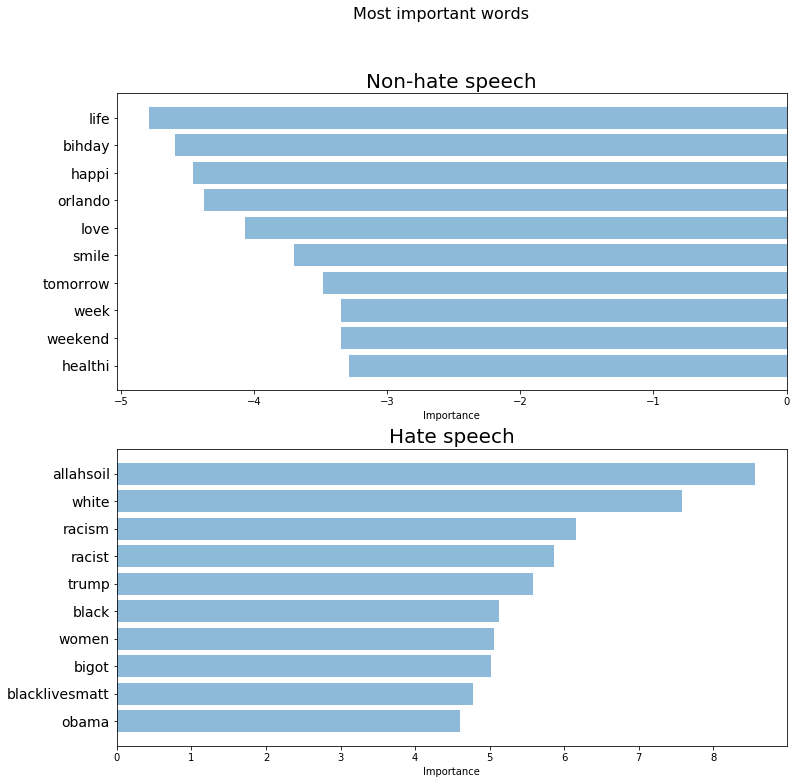

In [11]:
'''
Logistic regression with TF-IDF features
'''

tfv = TfidfVectorizer(min_df=3,
                      max_df=0.9, 
                      strip_accents='unicode',
                      analyzer='word',
                      token_pattern=r'\w{1,}',
                      ngram_range=(1, 3),
                      use_idf=1,smooth_idf=1,
                      sublinear_tf=1,
                      stop_words = 'english')


# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(xtrain) + list(xvalid))
xtrain_tfv =  tfv.transform(xtrain) 
xvalid_tfv = tfv.transform(xvalid)

from sklearn.linear_model import LogisticRegression
# Fitting a simple Logistic Regression on TFIDF
clf = LogisticRegression(C=1.0, class_weight='balanced')
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict(xvalid_tfv)

accuracy, precision, recall, f1, auc = get_metrics(yvalid, predictions)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))
print("auc = %.3f" % (auc))
importance = get_most_important_features(tfv, clf, 10)
print(confusion_matrix(yvalid, predictions))

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words")

store_results['LR_tfidf'] = "accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1)

Looking at the results we can say that we have a high recall and low precision. This means that our classifiers think there's a lot of tweets that are 'hate speech’. This means that we did classify correctly a lot of ‘hate speech’ category but there’s a lot of positive classifications that should be ‘non-hate speech’.

In [12]:
'''
Random forest with bag of words features
'''

from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(n_estimators= 500, n_jobs=-1, class_weight="balanced")
RF.fit(xtrain_ctv, ytrain)
predictions = RF.predict(xvalid_ctv)

accuracy, precision, recall, f1, auc = get_metrics(yvalid, predictions)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))
print("auc = %.3f" % (auc))
print(confusion_matrix(yvalid, predictions))

store_results['RF_bow'] = "accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1)

accuracy = 0.952, precision = 0.682, recall = 0.601, f1 = 0.639
auc = 0.790
[[4365   94]
 [ 134  202]]


In [13]:
'''
Random forest with TF-IDF features
'''

from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(n_estimators=500, n_jobs=-1, class_weight="balanced")
RF.fit(xtrain_tfv, ytrain)
predictions = RF.predict(xvalid_tfv)

accuracy, precision, recall, f1, auc = get_metrics(yvalid, predictions)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))
print("auc = %.3f" % (auc))
print(confusion_matrix(yvalid, predictions))

store_results['RF_tfidf'] = "accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1)

accuracy = 0.962, precision = 0.819, recall = 0.580, f1 = 0.679
auc = 0.785
[[4416   43]
 [ 141  195]]


Here we have the opposite scenario: low recall and high precision. This means that our classifier is much more conservative: the tweets it classifies as 'hate speech' are actually correct but it is missing a lot of them as well.

# Neural Network (NN) approach
The NN approach that will be used here is simple: input layer that will receive the whole sentences/tweets. Each tweet is converted into a vector (where each entry is a word) that will be fed to the NN, then each of the entries of that vector (each word) is mapped to it’s representation in the vector space - word embedding. After having all the words represented by a vector, we have a flatten layer that will then feed a sigmoid in order to have an output between 0 and 1.

In order to use as input the whole sentence we need to determine the maximum size (number of words) of our tweets. Below is an histogram with word counts of each tweet in our dataset.

321788 words total, with a vocabulary size of 38330
Max sentence length is 17


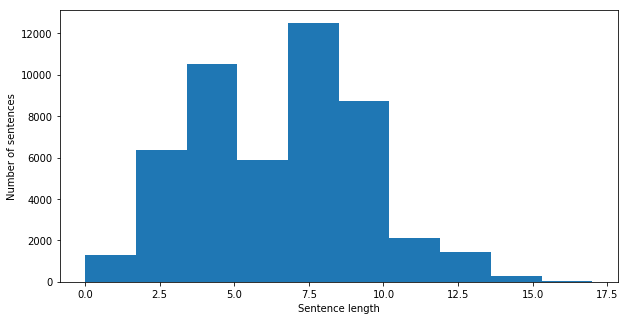

In [14]:
# histogram - number of words / tweet
all_words = [word for tokens in df['tokens_stemmed'] for word in tokens]
sentence_lengths = [len(tokens) for tokens in df['tokens_stemmed']]
vocab = sorted(list(set(all_words)))
print('%s words total, with a vocabulary size of %s' % (len(all_words), len(vocab)))
print("Max sentence length is %s" % max(sentence_lengths))

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 5)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

In [15]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import gensim
from keras.layers import Dense, Input, Flatten, Concatenate
from keras.layers import Embedding
from keras.models import Model, Sequential
from keras import backend as K
import tensorflow as tf

from numpy import array
from keras.preprocessing.text import one_hot

Using TensorFlow backend.


In [16]:
'''
Auxiliary functions for metrics while training NN
'''

def precision_(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall_(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1_score_(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [21]:
'''
Modeling with NN
'''
# define documents
docs = df[df.is_train == 1].clean_text_stemmed.values

# define class labels
labels = df[df.is_train == 1].target.values

# integer encode the documents
tokenizer = Tokenizer()
tokenizer.fit_on_texts(docs)
vocab_size = len(tokenizer.word_index) + 1
encoded_docs = [one_hot(d, vocab_size) for d in docs]

# pad documents to a max length of 4 words
max_length = max([len(t.split()) for t in docs])
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

# define the model
model = Sequential()
model.add(Embedding(vocab_size, 150, input_length=max_length))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=['accuracy', precision_, recall_, f1_score_])

# summarize the model
print(model.summary())

# split train and validation data according to what was used for previous models
x_train = np.array([i for idx,i in enumerate(padded_docs) if idx in xtrain_id.index.values])
y_train = np.array([i for idx,i in enumerate(labels) if idx in xtrain_id.index.values])
x_val = np.array([i for idx,i in enumerate(padded_docs) if idx in xvalid_id.index.values])
y_val = np.array([i for idx,i in enumerate(labels) if idx in xvalid_id.index.values])

# fit the model
class_weight = {0 : 1., 1: 1/(labels.sum()/len(labels))}
history = model.fit(x_train, y_train,  validation_data=(x_val, y_val), epochs=100, class_weight = class_weight, verbose=2)
predictions = model.predict_classes(x_val)

#accuracy, precision, recall, f1, auc = get_metrics(yvalid, predictions)
accuracy, precision, recall, f1, auc = get_metrics(y_val, predictions)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))
print("auc = %.3f" % (auc))

store_results['NN'] = "accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 16, 150)           4423650   
_________________________________________________________________
flatten_3 (Flatten)          (None, 2400)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2401      
Total params: 4,426,051
Trainable params: 4,426,051
Non-trainable params: 0
_________________________________________________________________
None
Train on 27167 samples, validate on 4795 samples
Epoch 1/100
 - 28s - loss: 0.8079 - acc: 0.8231 - precision_: 0.2726 - recall_: 0.7040 - f1_score_: 0.3633 - val_loss: 0.2465 - val_acc: 0.8997 - val_precision_: 0.3901 - val_recall_: 0.7311 - val_f1_score_: 0.4746
Epoch 2/100
 - 30s - loss: 0.2626 - acc: 0.9496 - precision_: 0.5817 - recall_: 0.8558 - f1_score_: 0.6651 - val_loss: 0.2351 -

Epoch 36/100
 - 28s - loss: 0.0054 - acc: 0.9994 - precision_: 0.8826 - recall_: 0.8845 - f1_score_: 0.8827 - val_loss: 0.5213 - val_acc: 0.9341 - val_precision_: 0.4762 - val_recall_: 0.5171 - val_f1_score_: 0.4650
Epoch 37/100
 - 28s - loss: 0.0057 - acc: 0.9994 - precision_: 0.8971 - recall_: 0.8997 - f1_score_: 0.8978 - val_loss: 0.5597 - val_acc: 0.9247 - val_precision_: 0.4328 - val_recall_: 0.5184 - val_f1_score_: 0.4440
Epoch 38/100
 - 28s - loss: 0.0053 - acc: 0.9995 - precision_: 0.8963 - recall_: 0.8983 - f1_score_: 0.8967 - val_loss: 0.5368 - val_acc: 0.9306 - val_precision_: 0.4571 - val_recall_: 0.5110 - val_f1_score_: 0.4532
Epoch 39/100
 - 28s - loss: 0.0054 - acc: 0.9994 - precision_: 0.8865 - recall_: 0.8889 - f1_score_: 0.8870 - val_loss: 0.5471 - val_acc: 0.9293 - val_precision_: 0.4509 - val_recall_: 0.5137 - val_f1_score_: 0.4507
Epoch 40/100
 - 28s - loss: 0.0053 - acc: 0.9994 - precision_: 0.9045 - recall_: 0.9067 - f1_score_: 0.9050 - val_loss: 0.5356 - val_acc

Epoch 74/100
 - 28s - loss: 0.0052 - acc: 0.9984 - precision_: 0.8914 - recall_: 0.9043 - f1_score_: 0.8964 - val_loss: 0.5577 - val_acc: 0.9310 - val_precision_: 0.4624 - val_recall_: 0.5074 - val_f1_score_: 0.4487
Epoch 75/100
 - 28s - loss: 0.0054 - acc: 0.9994 - precision_: 0.8947 - recall_: 0.8972 - f1_score_: 0.8952 - val_loss: 0.5582 - val_acc: 0.9306 - val_precision_: 0.4778 - val_recall_: 0.5243 - val_f1_score_: 0.4653
Epoch 76/100
 - 28s - loss: 0.0051 - acc: 0.9994 - precision_: 0.8980 - recall_: 0.8995 - f1_score_: 0.8983 - val_loss: 0.5580 - val_acc: 0.9308 - val_precision_: 0.4764 - val_recall_: 0.5243 - val_f1_score_: 0.4649
Epoch 77/100
 - 28s - loss: 0.0053 - acc: 0.9994 - precision_: 0.9058 - recall_: 0.9090 - f1_score_: 0.9066 - val_loss: 0.5718 - val_acc: 0.9260 - val_precision_: 0.4489 - val_recall_: 0.5260 - val_f1_score_: 0.4494
Epoch 78/100
 - 28s - loss: 0.0052 - acc: 0.9989 - precision_: 0.8915 - recall_: 0.8989 - f1_score_: 0.8941 - val_loss: 0.5629 - val_acc

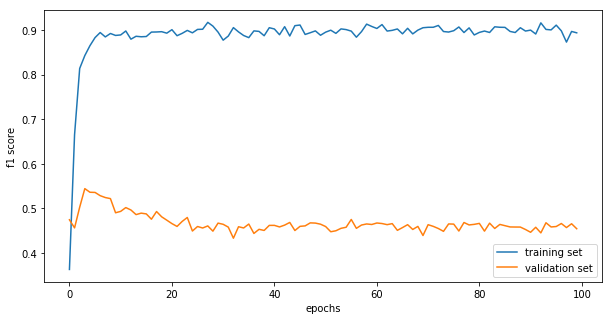

In [32]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

plt.plot(history.history['f1_score_'], label='training set')
plt.plot(history.history['val_f1_score_'], label='validation set')
plt.xlabel('epochs')
plt.ylabel('f1 score')
ax.legend(loc='best')
plt.show()

Although these results are worse when compared with previous results it is important to state that the approach is completely different and it lacks a fundamental step when we talk about NN: hyper parameter tuning: number of layers, number of neurons, dropout, learning rate, activation functions, etc.

So in the end, this is just a dummy/naive example to allow for further discussion if I step into the next stage of the recruitment process.

In [19]:
store_results

{'LR_bow': 'accuracy = 0.943, precision = 0.570, recall = 0.735, f1 = 0.642',
 'LR_tfidf': 'accuracy = 0.939, precision = 0.547, recall = 0.762, f1 = 0.637',
 'NN': 'accuracy = 0.936, precision = 0.547, recall = 0.524, f1 = 0.535',
 'RF_bow': 'accuracy = 0.952, precision = 0.682, recall = 0.601, f1 = 0.639',
 'RF_tfidf': 'accuracy = 0.962, precision = 0.819, recall = 0.580, f1 = 0.679'}

Looking at the results the best f1_score was obtained using random forests with tf-idf features.